# Training modules overview

In [ ]:
from fastai.basic_train import *
from fastai.gen_doc.nbdoc import *
from fastai.vision import *
from fastai.callbacks import *

The fastai library structures its training process around the [`Learner`](/basic_train.html#Learner) class, whose object binds together a PyTorch model, a dataset, an optimizer, and a loss function; the entire learner object then will allow us to launch training.

[`basic_train`](/basic_train.html#basic_train) defines this [`Learner`](/basic_train.html#Learner) class, along with the wrapper around the PyTorch optimizer that the library uses. It documents the basic training loop that is used each time you call the [`fit`](/basic_train.html#fit) function(or one of its variants) in fastai. A training loop method requires an intentionally minimal number of arguments; if you want to customize your training loop, you could include in the arguments an optional [`Callback`](/callback.html#Callback) object, which provides a rich number of customization options for the training loop.

[`callback`](/callback.html#callback) defines these customization options and the [`CallbackHandler`](/callback.html#CallbackHandler) that is responsible for the communication between the training loop and the [`Callback`](/callback.html#Callback)'s methods. The [`CallbackHandler`](/callback.html#CallbackHandler) maintains a state dictionary able to provide each [`Callback`](/callback.html#Callback) object all the information of the training loop it belongs to, making any imaginable tweaks of the training loop within your reach.

[`callbacks`](/callbacks.html#callbacks) implements each predefined [`Callback`](/callback.html#Callback) class of the fastai library in separate modules. Some deal with scheduling the hyperparameters, like [`callbacks.one_cycle`](/callbacks.one_cycle.html#callbacks.one_cycle), [`callbacks.lr_finder`](/callbacks.lr_finder.html#callbacks.lr_finder) or [`callback.general_sched`](/callbacks.general_sched.html#callbacks.general_sched). Others allow special kinds of training like [`callbacks.fp16`](/callbacks.fp16.html#callbacks.fp16) (mixed precision) or [`callbacks.rnn`](/callbacks.rnn.html#callbacks.rnn). The [`Recorder`](/basic_train.html#Recorder) and [`callbacks.hooks`](/callbacks.hooks.html#callbacks.hooks) are useful to save some internal data generated in the training loop.

[`train`](/train.html#train) then uses these callbacks to implement useful helper functions. Lastly, [`metrics`](/metrics.html#metrics) contains all the functions you might want to call to evaluate your training results.

## Walk-through of key functionalities

We'll do a quick overview of the key pieces of fastai's training modules. See the separate module docs for details on each. We'll use a small subset of the classic MNIST dataset containing the images of just 3's and 7's for the purpose of demo and documentation here. To minimize the boilerplate in our docs, we've defined a function to grab the data from <code>URLs.MNIST_SAMPLE</code>. The function will automatically download the dataset and unzips it if necessarty, which we then will use to create an [`ImageDataBunch`](/vision.data.html#ImageDataBunch) object

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

### Basic training with [`Learner`](/basic_train.html#Learner)

We can create minimal CNNs using [`simple_cnn`](/layers.html#simple_cnn) (see [`models`](/vision.models.html#vision.models) for details on creating models):

In [ ]:
model = simple_cnn((3,16,16,2))

Objects of the [`Learner`](/basic_train.html#Learner) class plays a central role in training models; they needs to know, at the very minimum, what data to train with and what exact kind of model to train.

In [ ]:
learn = Learner(data, model)

These are enough to create a [`Learner`](/basic_train.html#Learner) object and then use it to train a model using its [`fit`](/basic_train.html#fit) method. If you have a CUDA-enabled GPU, it will be used automatically. To call the [`fit`](/basic_train.html#fit) method, you have to at least specify how many epochs to train for.

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss
1,0.134623,0.107828


### Viewing metrics

To see how our training is going, we can request that it reports various kinds of [`metrics`](/metrics.html#metrics) after each epoch. You can pass it to the constructor, or set it later. Note that metrics is always calculated on the validation set.

In [ ]:
learn.metrics=[accuracy]
learn.fit(1)

epoch,train_loss,valid_loss,accuracy
1,0.091187,0.070155,0.976448


### Extending training with callbacks

You can use [`callback`](/callback.html#callback)s to modify training in almost any way you can imagine. For instance, we've provided a callback to implement Leslie Smith's 1cycle training method.

In [ ]:
cb = OneCycleScheduler(learn, lr_max=0.01)
learn.fit(1, callbacks=cb)

epoch,train_loss,valid_loss,accuracy
1,0.069892,0.044953,0.985280


The [`Recorder`](/basic_train.html#Recorder) callback is automatically added for you, and you can use it to see what happened in your training, e.g.:

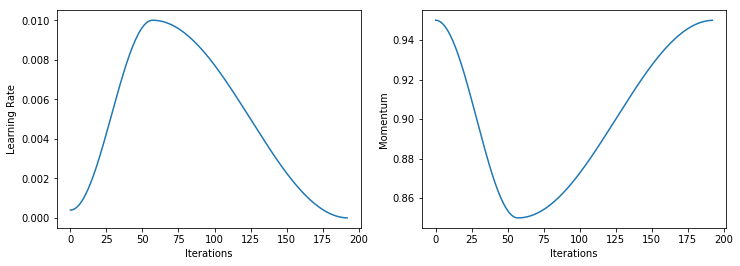

In [ ]:
learn.recorder.plot_lr(show_moms=True)

### Extending [`Learner`](/basic_train.html#Learner) with [`train`](/train.html#train)

Many of the callbacks can be used more easily by taking advantage of the [`Learner`](/basic_train.html#Learner) extensions in [`train`](/train.html#train). For instance, instead of creating OneCycleScheduler manually as above, you can simply call [`Learner.fit_one_cycle`](/train.html#fit_one_cycle):

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.053041,0.035323,0.988224


### Applications

Note that if you're training a model for one of our supported *applications*, there's a lot of help available to you in the application modules:

- [`vision`](/vision.html#vision)
- [`text`](/text.html#text)
- [`tabular`](/tabular.html#tabular)
- [`collab`](/collab.html#collab)

For instance, let's use [`create_cnn`](/vision.learner.html#create_cnn) (from [`vision`](/vision.html#vision)) to quickly fine-tune a pre-trained Imagenet model for MNIST (not a very practical approach, of course, since MNIST is handwriting and our model is pre-trained on photos!).

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.167131,0.109349,0.963199
